In [1]:
!pip install scikit-learn xgboost lightgbm catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.3 MB/s eta 0:00:00


In [46]:
import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import phik
from phik.report import plot_correlation_matrix
from phik import report
import skopt
from skopt import BayesSearchCV
from joblib import dump

In [62]:
df = pd.read_excel('Subjects Components Filtered.xlsx')
df2 = pd.read_excel('SubjectsSeverity.xlsx')

In [63]:
df = df.merge(df2, how='inner', on='Subject')

In [64]:
mapping = {"Mild": 0, "Moderate": 1, "Severe": 2}
df['Severity'] = df['Severity'].replace(mapping)
df.head()

,Healthy/Eczema,Subject,Ceramide 2,Ceramide 3,Lactic Acid,PCA,Uric Acid,Urea,Melanin,Cholesterol,Watermass,Spectra,Severity,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Eczema,EC001,0.0,0.120289,0.026488,0.060566,0.000749,0.021031,2.230477,0.000000,43709.818546,ok,2.0,NaN,NaN,Eczema ok:,15.0
1,Eczema,EC002,0.0,0.110608,0.086276,0.040751,0.000102,0.013240,0.037265,0.001449,50761.610963,ok,2.0,NaN,NaN,Healthy ok:,7.0
2,Eczema,EC003,0.0,0.146709,0.051836,0.073384,0.000108,0.008633,2.728881,0.001867,39431.720135,ok,2.0,NaN,NaN,NaN,NaN
3,Eczema,EC004,0.0,0.306053,0.229205,0.264416,0.006567,0.024359,12.517264,0.000000,24836.572041,ok,2.0,NaN,NaN,NaN,NaN
4,Eczema,EC006,0.0,0.270734,0.129418,0.070845,0.000929,0.005694,0.733396,0.003287,76318.466566,ok,1.0,NaN,NaN,NaN,NaN


In [65]:
df = df.iloc[:, :-4]
df = df[df.Severity.notnull()]

In [66]:
df = df.drop("Subject", axis=1).drop("Spectra", axis=1).drop('Healthy/Eczema', axis=1)

# Analysis of Data

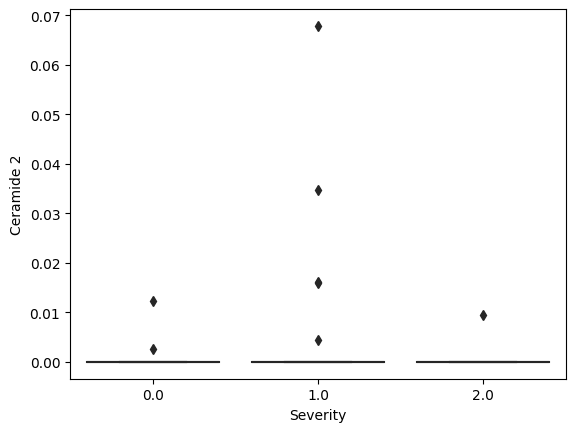

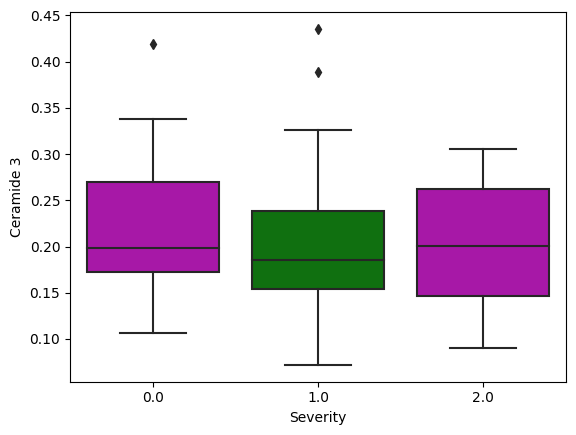

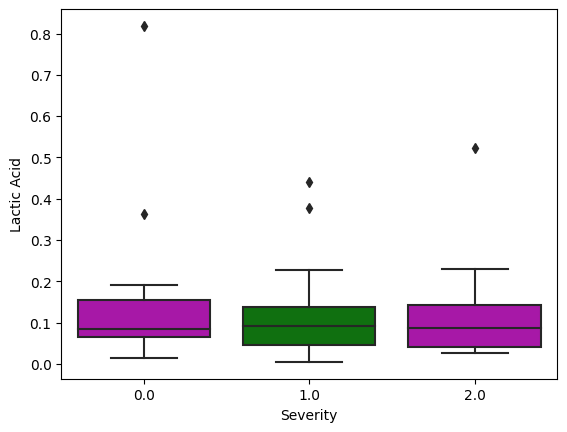

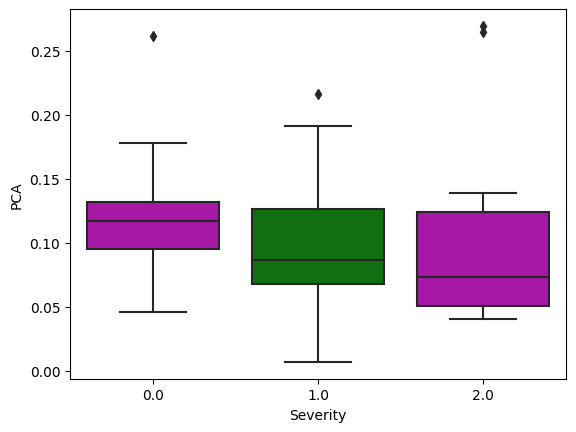

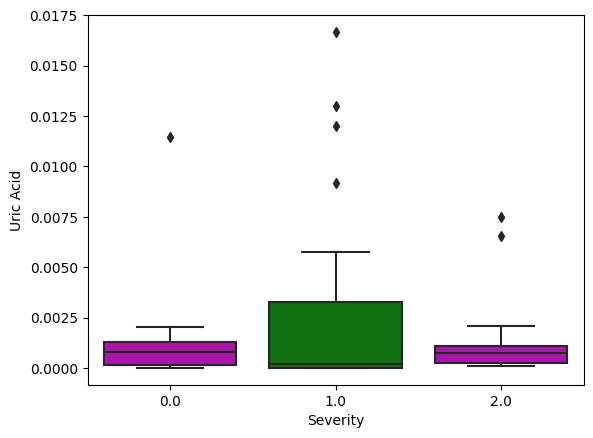

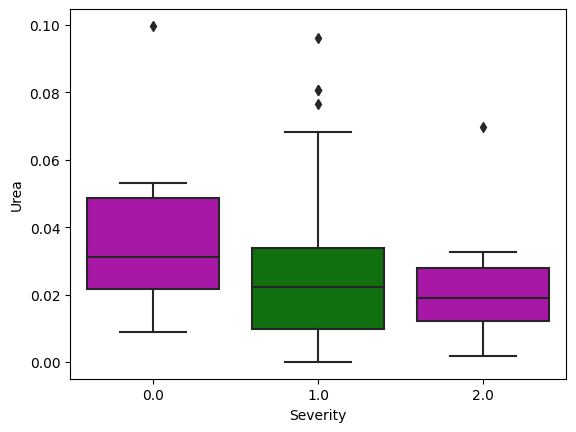

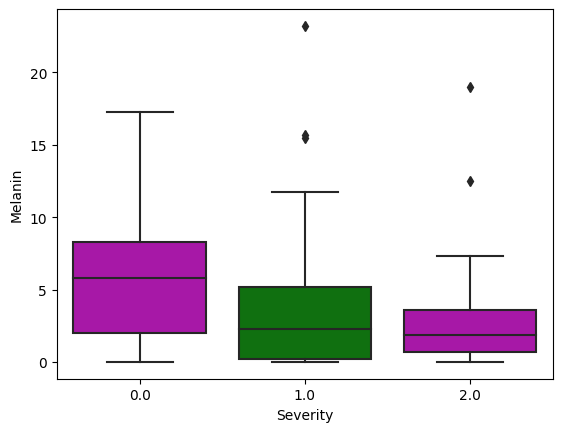

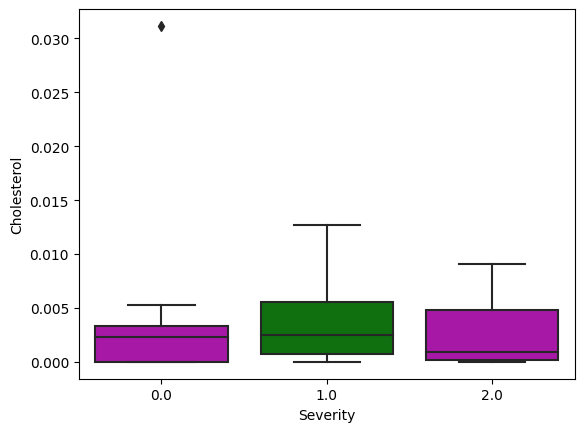

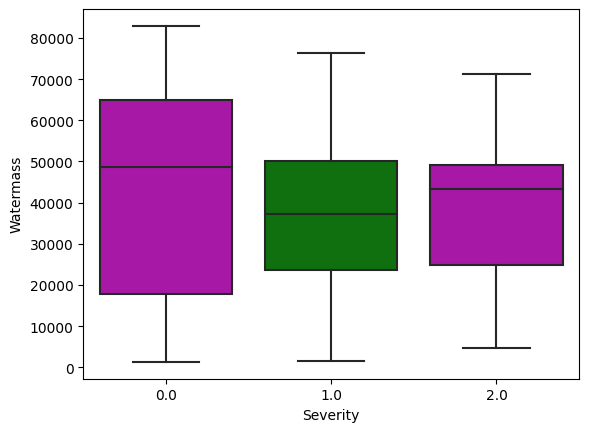

In [67]:
for i in df.columns[:-1]:
    sns.boxplot(x="Severity", y=i,palette=["m", "g"],data=df)
    plt.show()

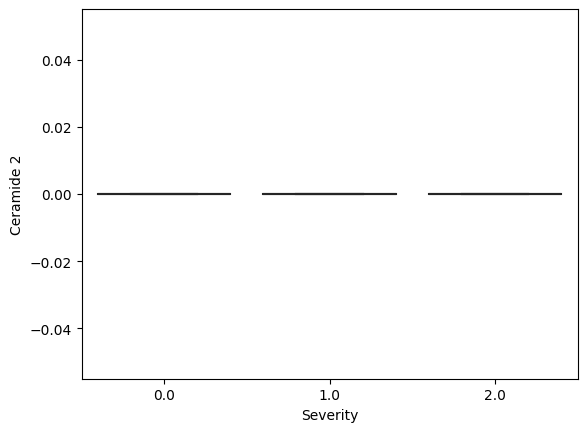

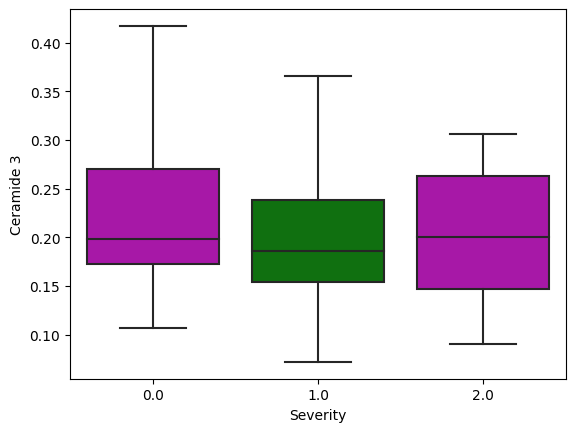

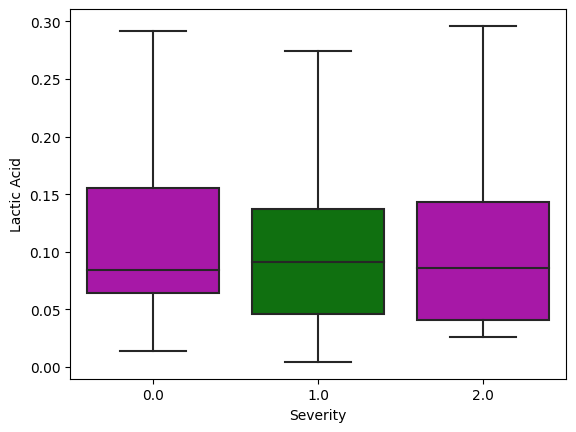

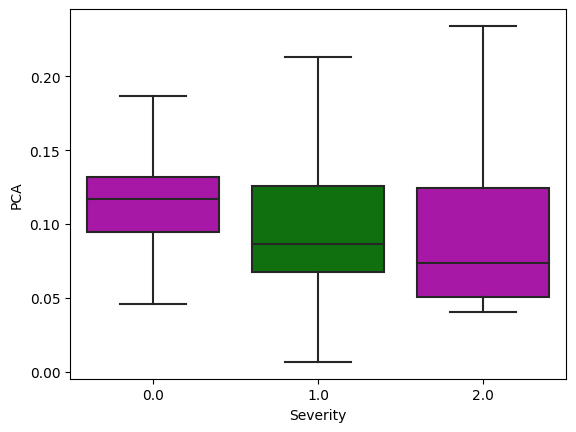

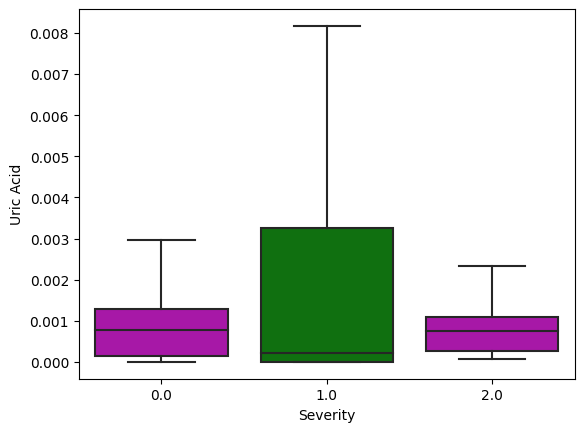

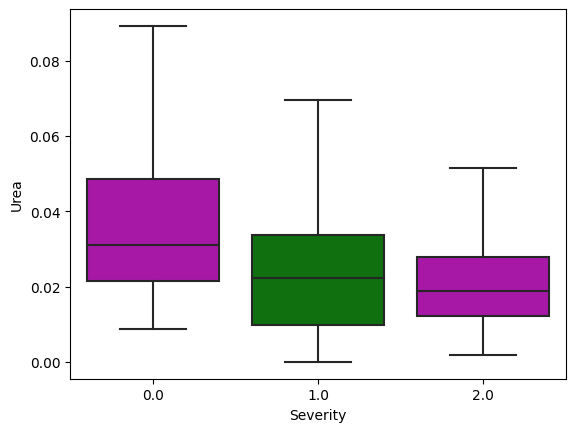

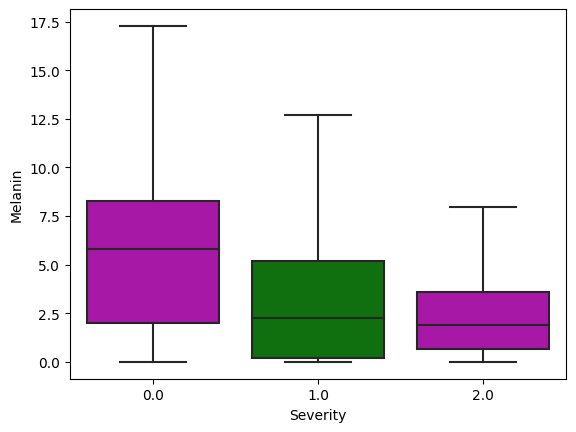

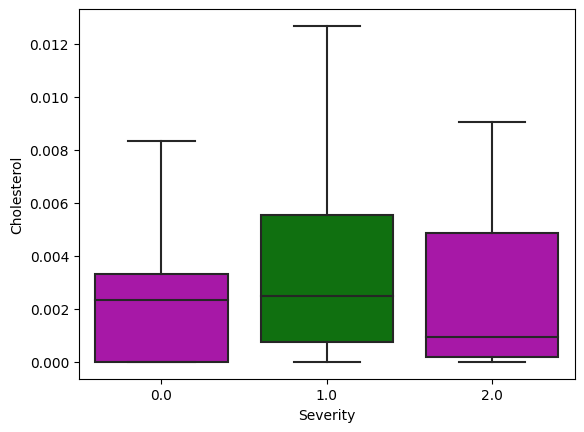

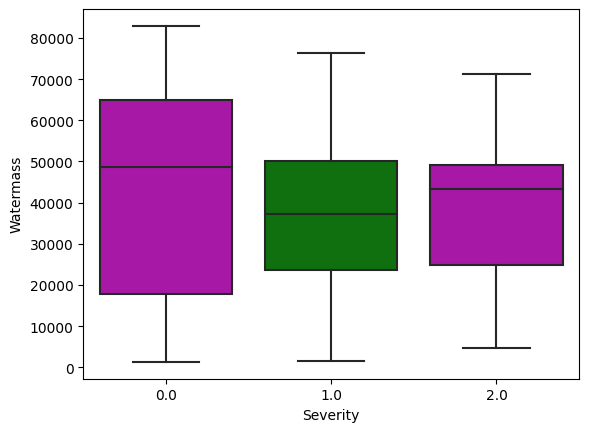

In [68]:
for col in df.columns[:-1]:
    for cls in range(3):
        percentile25 = df.loc[df['Severity']==cls][col].quantile(0.25)
        percentile75 = df.loc[df['Severity']==cls][col].quantile(0.75)
        iqr = percentile75 - percentile25
        upper_limit = percentile75 + 1.5 * iqr
        lower_limit = percentile25 - 1.5 * iqr
        df.loc[df['Severity']==cls, col] = np.where(
            df.loc[df['Severity']==cls][col] > upper_limit,
            upper_limit,
            np.where(
                df.loc[df['Severity']==cls][col] < lower_limit,
                lower_limit,
                df.loc[df['Severity']==cls][col]
            )
        )
    sns.boxplot(x="Severity", y=col, palette=["m", "g"],data=df)
    plt.show()

In [69]:
pipeline = Pipeline([
    ('scaling', ColumnTransformer([
        ('standard_scaler', StandardScaler(), df.columns[:-1])
    ])),
    ('minmax_scaler', MinMaxScaler())
])

transformed_data = pipeline.fit_transform(df)
df.iloc[:, :-1] = transformed_data

interval columns not set, guessing: ['Ceramide 2', 'Ceramide 3', 'Lactic Acid', 'PCA', 'Uric Acid', 'Urea', 'Melanin', 'Cholesterol', 'Watermass', 'Severity']


C:\Users\Mahir\anaconda3\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable Ceramide 2 for analysis 1. Dropping this column
  warnings.warn(


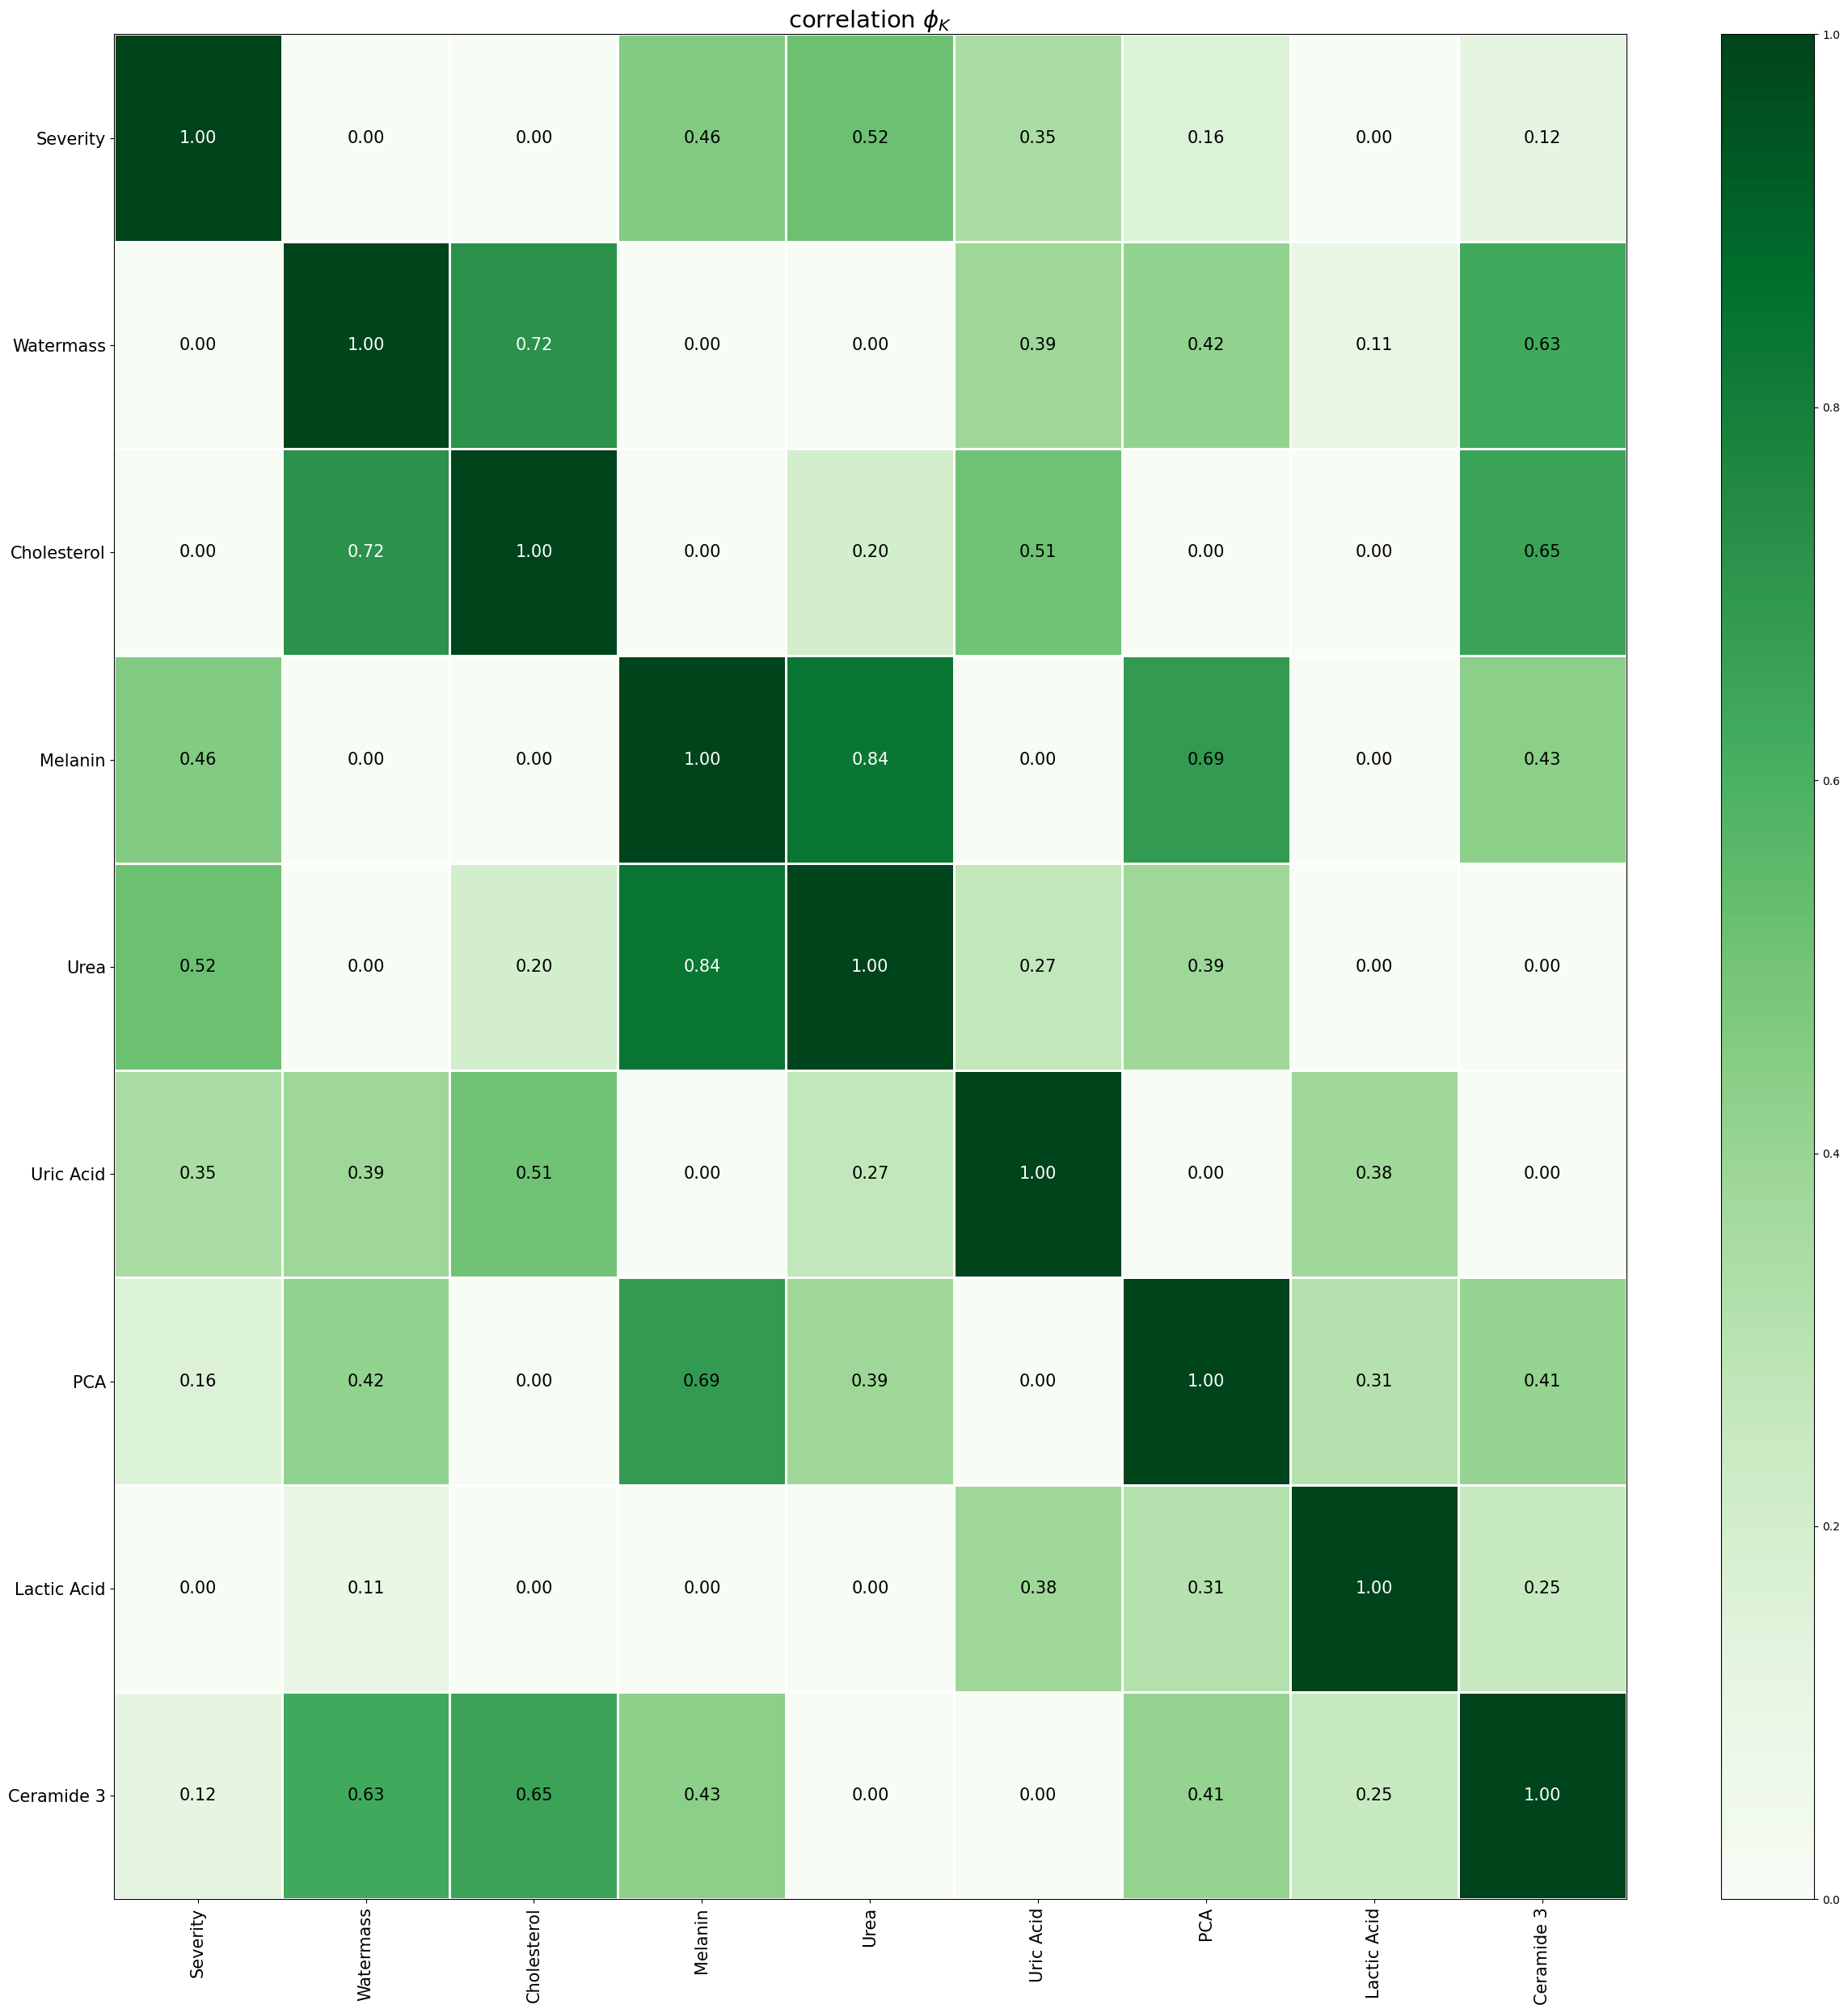

In [70]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(25,25))

interval columns not set, guessing: ['Ceramide 2', 'Ceramide 3', 'Lactic Acid', 'PCA', 'Uric Acid', 'Urea', 'Melanin', 'Cholesterol', 'Watermass', 'Severity']


C:\Users\Mahir\anaconda3\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable Ceramide 2 for analysis 1. Dropping this column
  warnings.warn(


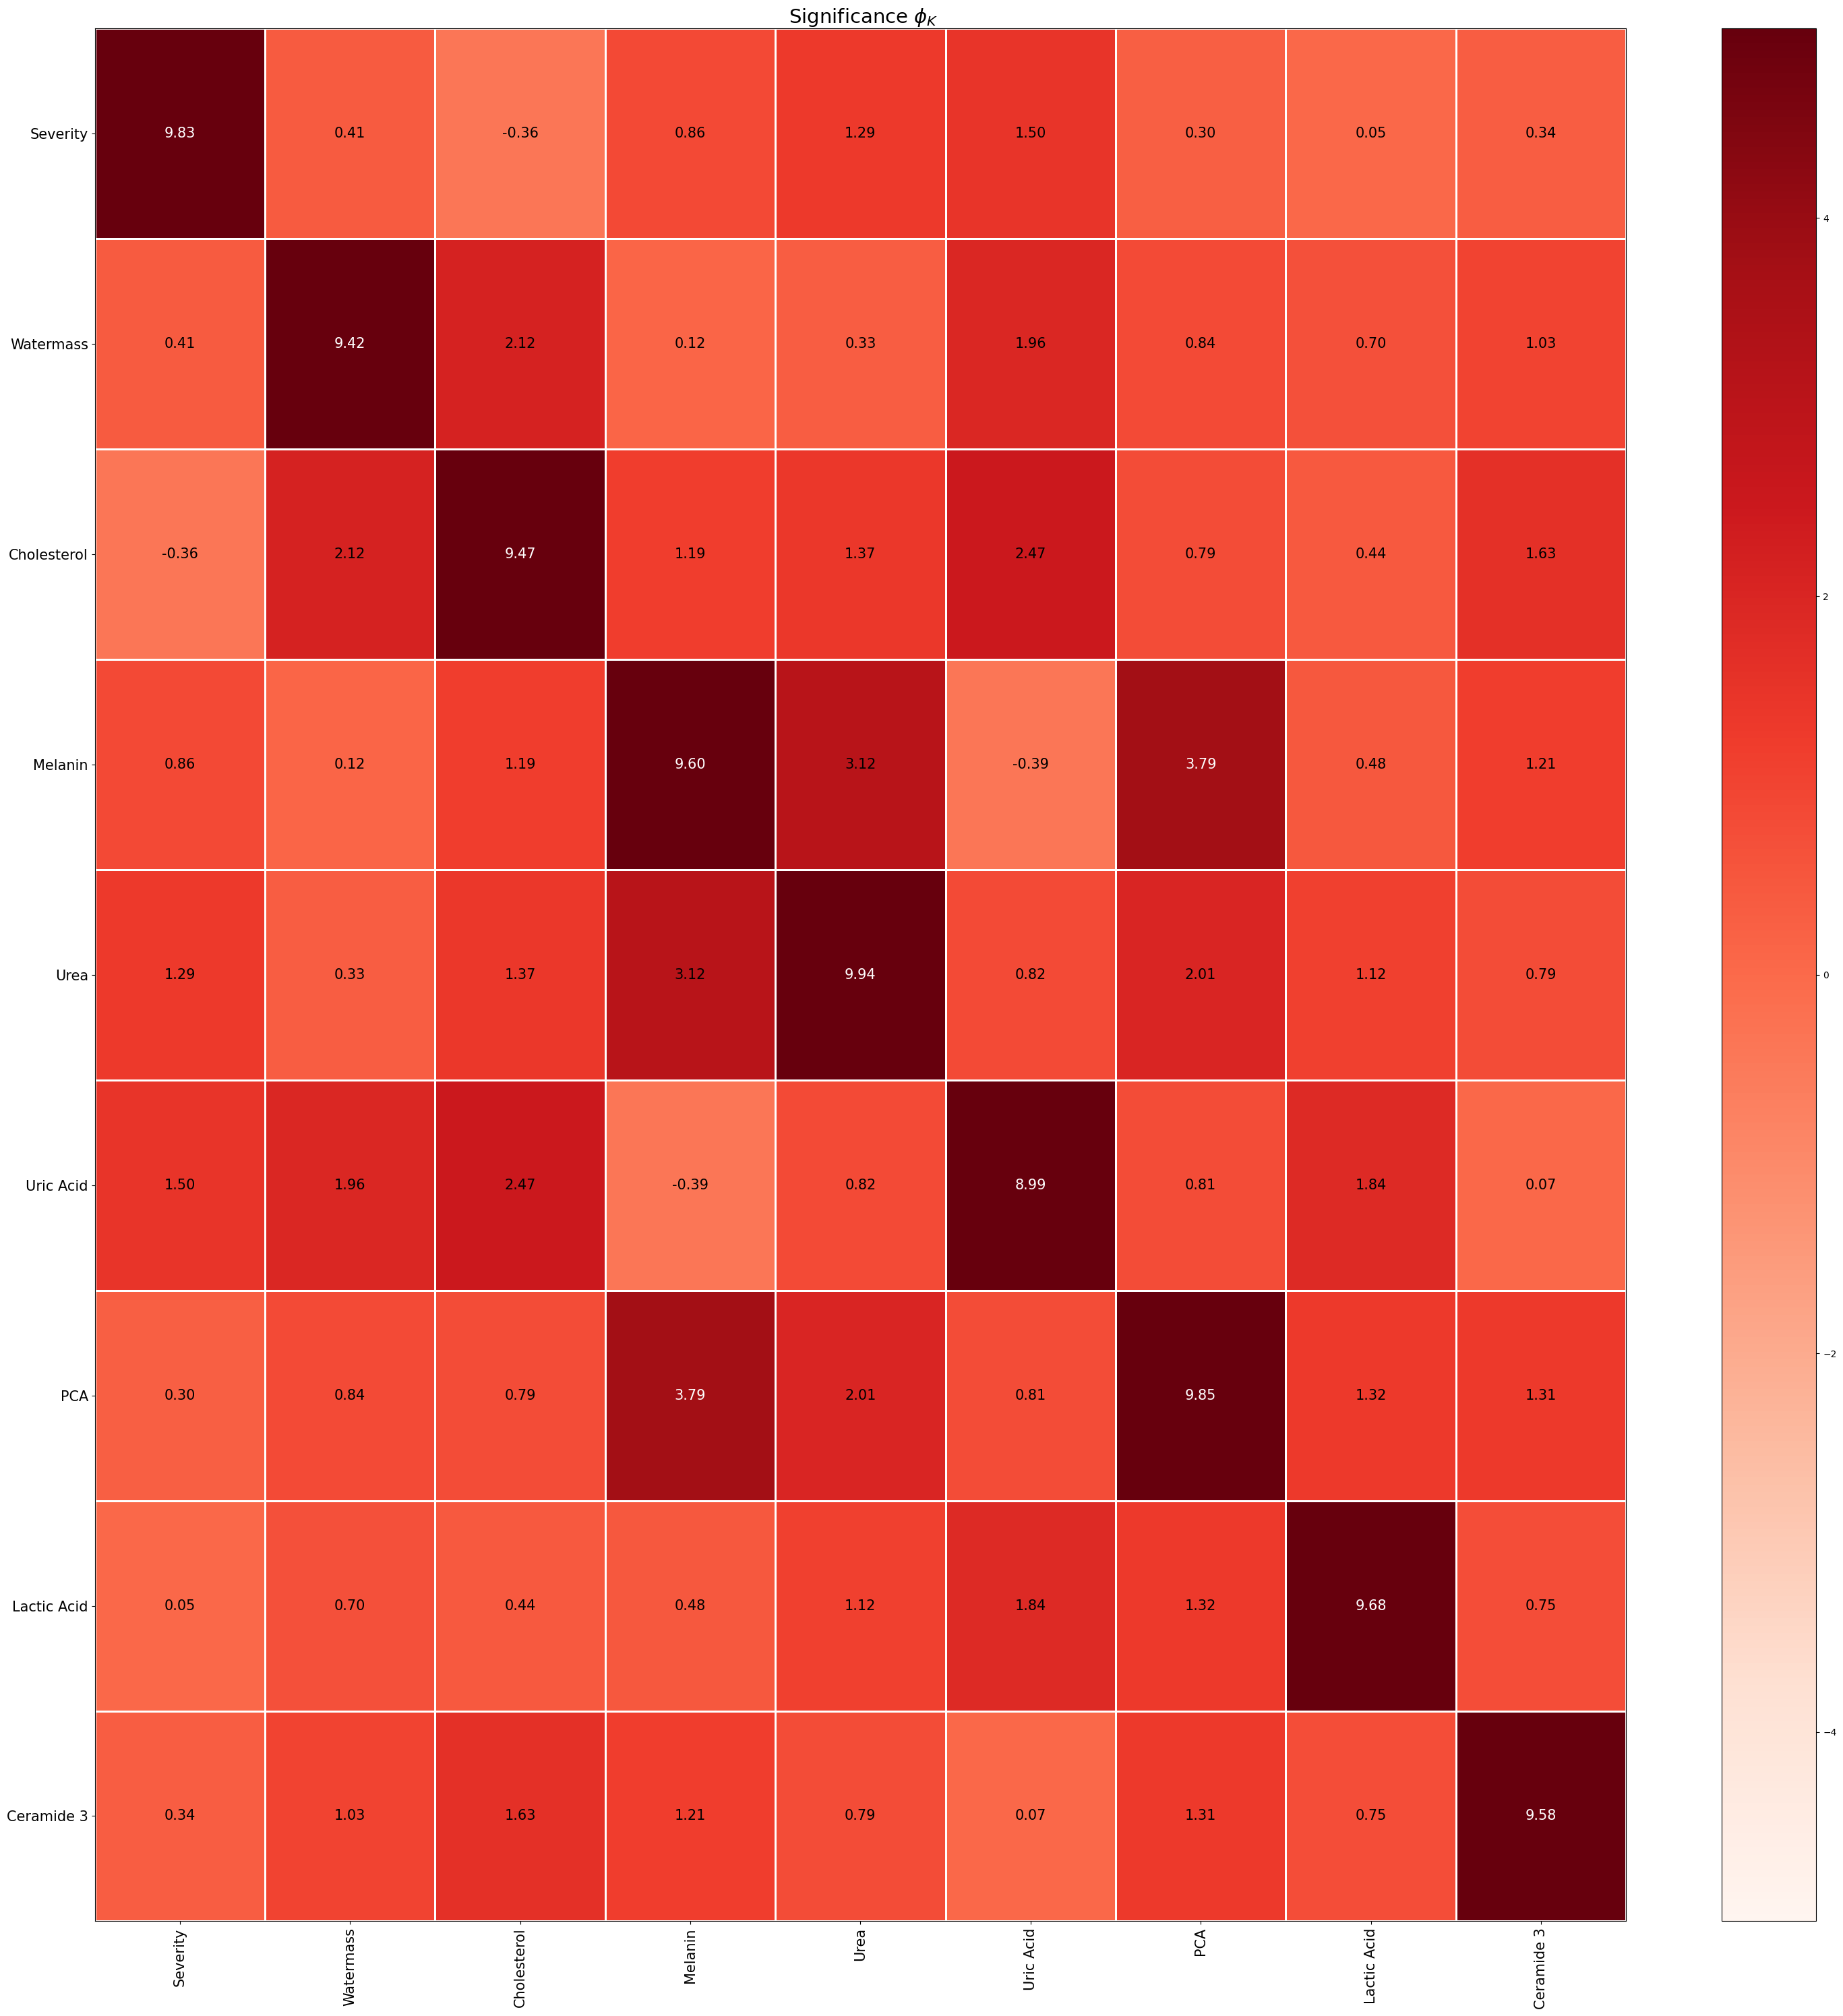

In [71]:
significancematrix = df.significance_matrix()
plot_correlation_matrix(significancematrix.values, x_labels=significancematrix.columns, y_labels=significancematrix.index, 
                        vmin=-5, vmax=5, color_map='Reds', title=r' Significance $\phi_K$', fontsize_factor=1.5,
                        figsize=(30,30))

In [72]:
df = df.drop('Cholesterol', axis=1)
df = df.drop('Lactic Acid', axis=1)

In [83]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y , random_state=100)

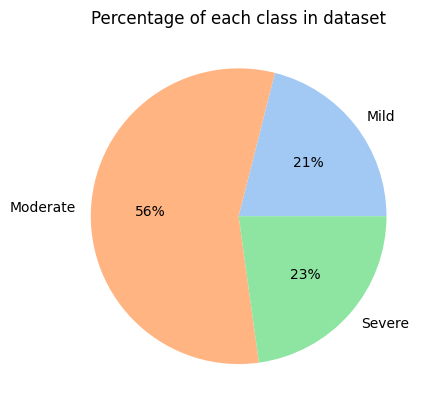

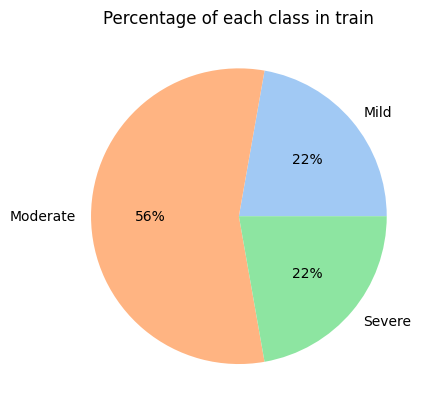

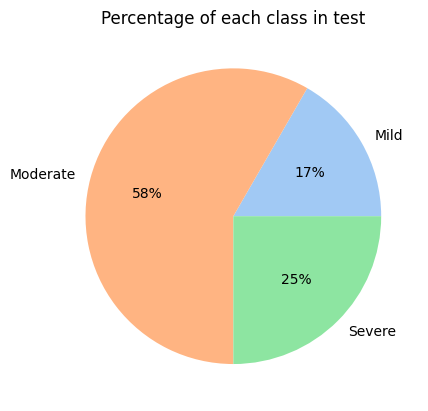

In [101]:
plt.pie([len(df[df['Severity']==0]), len(df[df['Severity']==1]), len(df[df['Severity']==2])], labels =  ['Mild', 'Moderate', 'Severe'], colors = sns.color_palette('pastel')[:3], autopct='%.0f%%')
plt.title('Percentage of each class in dataset')
plt.show()
plt.pie([len(y_train[y_train==0]), len(y_train[y_train==1]), len(y_train[y_train==2])], labels =  ['Mild', 'Moderate', 'Severe'], colors = sns.color_palette('pastel')[:3], autopct='%.0f%%')
plt.title('Percentage of each class in train')
plt.show()
plt.pie([len(y_test[y_test==0]), len(y_test[y_test==1]), len(y_test[y_test==2])], labels = ['Mild', 'Moderate', 'Severe'], colors = sns.color_palette('pastel')[:3], autopct='%.0f%%')
plt.title('Percentage of each class in test')
plt.show()

In [90]:
import skopt
from skopt import BayesSearchCV
classifiers = {
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }),
    'AdaBoost': (AdaBoostClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.01, 0.001]
    }),
    'XGBoost': (xgb.XGBClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }),
    'LightGBM': (lgb.LGBMClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }),
    'CatBoost': (CatBoostClassifier(silent=True), {
        'iterations': [50, 100, 200],
        'learning_rate': [0.1, 0.01, 0.001],
        'depth': [3, 5, 7],
    }),
}

models = []
for clf_name, (clf, param_bayes) in classifiers.items():
    bayes_search = BayesSearchCV(clf, param_bayes, cv=5)
    bayes_search.fit(X_train, y_train)

    best_score = bayes_search.best_score_
    best_params = bayes_search.best_params_

    print(f"Results for {clf_name}:")
    print("Best cross-validation accuracy:", best_score)
    print("Best hyperparameters:", best_params)
    print("-----------------------------------")
    
    best_model = bayes_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print("Test accuracy:", test_score)
    print("-----------------------------------")
    
    y_pred = best_model.predict(X_test)
    print(sklearn.metrics.classification_report(y_test, y_pred))
    
    models.append(best_model)


C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for Random Forest:
Best cross-validation accuracy: 0.5777777777777777
Best hyperparameters: OrderedDict([('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 4), ('n_estimators', 200)])
-----------------------------------
Test accuracy: 0.5833333333333334
-----------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.58      1.00      0.74         7
         2.0       0.00      0.00      0.00         3

    accuracy                           0.58        12
   macro avg       0.19      0.33      0.25        12
weighted avg       0.34      0.58      0.43        12



C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimi

Results for K-Nearest Neighbors:
Best cross-validation accuracy: 0.5777777777777777
Best hyperparameters: OrderedDict([('algorithm', 'ball_tree'), ('n_neighbors', 7), ('weights', 'distance')])
-----------------------------------
Test accuracy: 0.5
-----------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.60      0.86      0.71         7
         2.0       0.00      0.00      0.00         3

    accuracy                           0.50        12
   macro avg       0.20      0.29      0.24        12
weighted avg       0.35      0.50      0.41        12



C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimi

Results for Decision Tree:
Best cross-validation accuracy: 0.5555555555555556
Best hyperparameters: OrderedDict([('max_depth', 5), ('max_features', 'log2'), ('min_samples_leaf', 4)])
-----------------------------------
Test accuracy: 0.5833333333333334
-----------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.67      0.86      0.75         7
         2.0       0.50      0.33      0.40         3

    accuracy                           0.58        12
   macro avg       0.39      0.40      0.38        12
weighted avg       0.51      0.58      0.54        12



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for AdaBoost:
Best cross-validation accuracy: 0.5777777777777778
Best hyperparameters: OrderedDict([('learning_rate', 0.01), ('n_estimators', 50)])
-----------------------------------
Test accuracy: 0.5833333333333334
-----------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.64      1.00      0.78         7
         2.0       0.00      0.00      0.00         3

    accuracy                           0.58        12
   macro avg       0.21      0.33      0.26        12
weighted avg       0.37      0.58      0.45        12



C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimi

Results for XGBoost:
Best cross-validation accuracy: 0.5555555555555556
Best hyperparameters: OrderedDict([('colsample_bytree', 0.8), ('learning_rate', 0.001), ('max_depth', 3), ('n_estimators', 50), ('subsample', 0.8224026286550948)])
-----------------------------------
Test accuracy: 0.5833333333333334
-----------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.64      1.00      0.78         7
         2.0       0.00      0.00      0.00         3

    accuracy                           0.58        12
   macro avg       0.21      0.33      0.26        12
weighted avg       0.37      0.58      0.45        12



C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for LightGBM:
Best cross-validation accuracy: 0.5555555555555556
Best hyperparameters: OrderedDict([('colsample_bytree', 0.9684997359789141), ('learning_rate', 0.01), ('max_depth', 3), ('n_estimators', 50), ('subsample', 0.9967746706543784)])
-----------------------------------
Test accuracy: 0.5833333333333334
-----------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.58      1.00      0.74         7
         2.0       0.00      0.00      0.00         3

    accuracy                           0.58        12
   macro avg       0.19      0.33      0.25        12
weighted avg       0.34      0.58      0.43        12



C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimi

Results for CatBoost:
Best cross-validation accuracy: 0.5777777777777778
Best hyperparameters: OrderedDict([('depth', 5), ('iterations', 50), ('learning_rate', 0.001)])
-----------------------------------
Test accuracy: 0.5833333333333334
-----------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.64      1.00      0.78         7
         2.0       0.00      0.00      0.00         3

    accuracy                           0.58        12
   macro avg       0.21      0.33      0.26        12
weighted avg       0.37      0.58      0.45        12



C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)
bagging_clf.fit(X_train, y_train)
y_pred = bagging_clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred))

C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.70      1.00      0.82         7
         2.0       0.50      0.33      0.40         3

    accuracy                           0.67        12
   macro avg       0.40      0.44      0.41        12
weighted avg       0.53      0.67      0.58        12



C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
estimators = [(name, clf) for name, (clf, _) in classifiers.items()]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=xgb.XGBClassifier())
stacking_clf.fit(X_train, y_train)

y_pred = stacking_clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred))

C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.33      0.50      0.40         2
         1.0       0.67      0.86      0.75         7
         2.0       0.00      0.00      0.00         3

    accuracy                           0.58        12
   macro avg       0.33      0.45      0.38        12
weighted avg       0.44      0.58      0.50        12



C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
del models[1]
sm = np.zeros(len(X.columns))
for model in models:
    importances = model.feature_importances_
    sm += np.array(importances)

In [95]:
base_estimator_importances = np.zeros(len(X.columns))  
for estimator in stacking_clf.estimators:
    if hasattr(estimator, 'feature_importances_'):
        base_estimator_importances += estimator.feature_importances_
base_estimator_importances = base_estimator_importances/len(models)

In [96]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagging_clf.estimators_
], axis=0)

In [97]:
len(models)

6

In [98]:
feature_importances = (base_estimator_importances + sm + feature_importances) / 8

<Axes: title={'center': 'Average Feature Importance of all classifiers'}, xlabel='Features', ylabel='Feature Importance'>

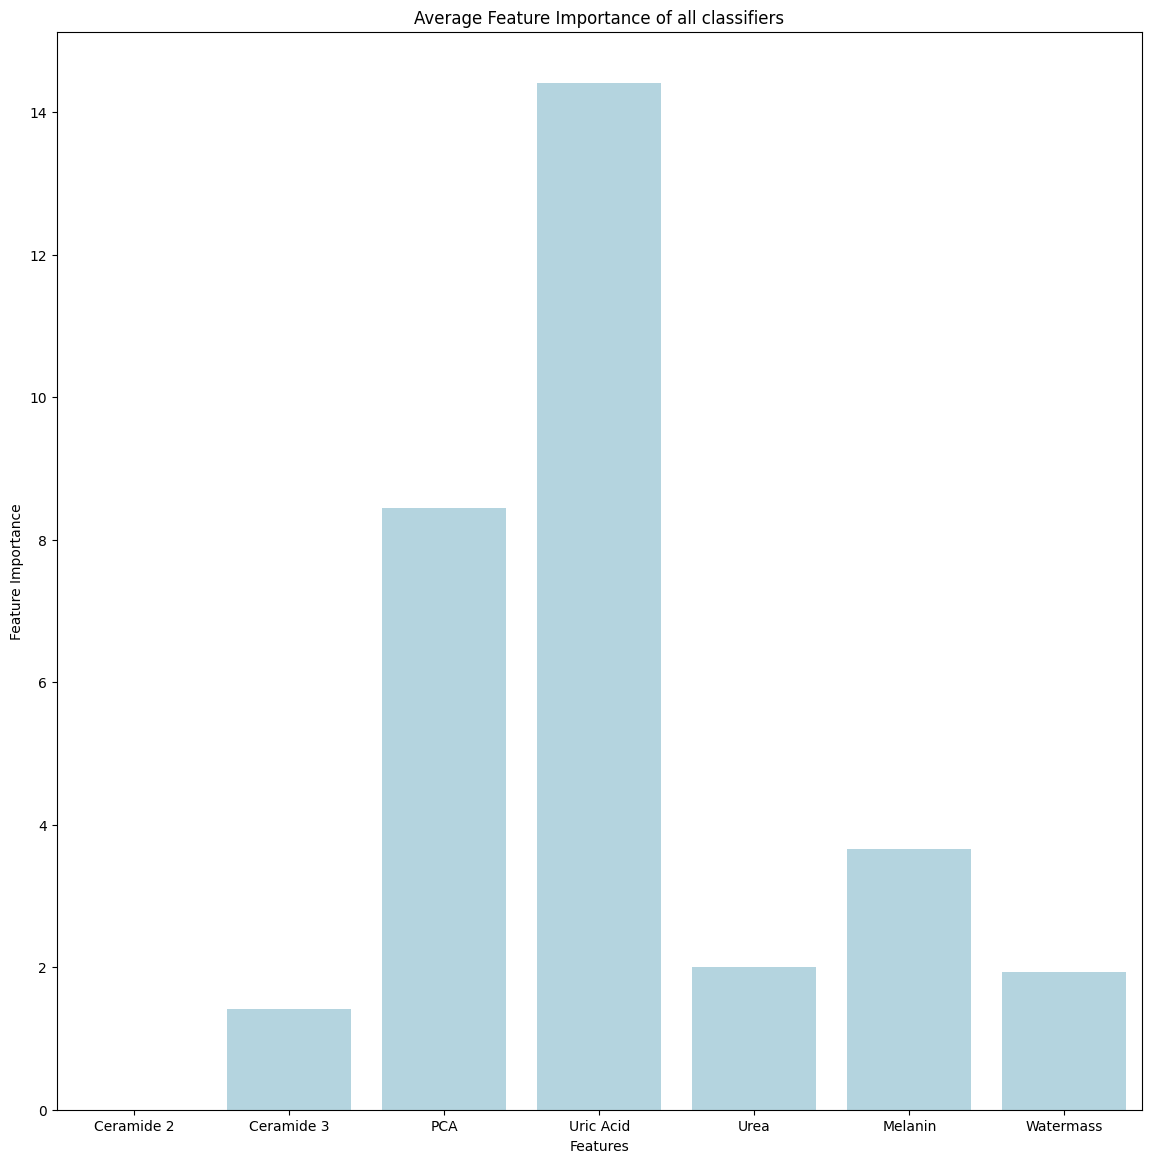

In [99]:
import matplotlib.pyplot

plt.figure(figsize=(14, 14))
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Average Feature Importance of all classifiers')
sns.barplot(y=feature_importances, x=X.columns, color='b', palette=['lightblue'])